<a href="https://colab.research.google.com/github/Barryugo/Disease-detection/blob/main/disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gdown

In [3]:
!pip install split-folders
!pip install TensorFlow

In [4]:
import os
import tensorflow as tf
import cv2, pathlib, splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import drive

In [5]:
from google.colab import files
import zipfile
import io

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!gdown --id 1tMMrivJDCM62PEuXHUnOG1YKH9KI6Lfv


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1tMMrivJDCM62PEuXHUnOG1YKH9KI6Lfv
To: /content/archive.zip
100% 169M/169M [00:04<00:00, 40.7MB/s]


In [8]:
!unzip -uq "archive.zip" -d "Disease_detection"


In [9]:
!ls /content/Disease_detection/data


Blight	Common_Rust  Gray_Leaf_Spot  Healthy


In [10]:
# import the libraries
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
import splitfolders

# set the parameters
epochs = 30
batch_size = 32
img_height, img_width = 300, 300
input_shape = (img_height, img_width, 3)

# create the data generator and split the dataset
data_gen = ImageDataGenerator(rescale=1.0 / 255)
splitfolders.ratio('/content/Disease_detection/data', output='Imgs/', seed=1234, ratio=(0.7, 0.15, 0.15), group_prefix=None)

# create the train and validation datasets
train_ds = data_gen.flow_from_directory('Imgs/train/', target_size=(img_height, img_width),
                                        class_mode='sparse', batch_size=batch_size, subset='training')
val_ds = data_gen.flow_from_directory('Imgs/val/', target_size=(img_height, img_width),
                                      class_mode='sparse', batch_size=batch_size, shuffle=False)

# load the pretrained model and freeze its weights
base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False

# create the transfer learning model
from tensorflow.keras.layers import GlobalAveragePooling2D
model_tr = Sequential()
model_tr.add(base_model)
model_tr.add(GlobalAveragePooling2D())
model_tr.add(Dense(256, activation='relu'))
model_tr.add(Dropout(0.3))
model_tr.add(Dense(4, activation='softmax'))


# compile and train the model
model_tr.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = './Model.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    model_tr.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path, save_weights_only=True,
                                                 save_best_only=True)

history = model_tr.fit(train_ds, epochs=epochs, batch_size=batch_size, validation_data=val_ds, callbacks=[cp_callback])

model_tr.summary()

file = open('./weights.txt', 'w')
for v in model_tr.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')

file.close()


Copying files: 4188 files [00:00, 6133.32 files/s]


Found 2930 images belonging to 4 classes.
Found 626 images belonging to 4 classes.
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/30
92/92 [==============================] - 45s 329ms/step - loss: 1.4082 - sparse_categorical_accuracy: 0.3652 - val_loss: 1.2127 - val_sparse_categorical_accuracy: 0.5655
Epoch 2/30
92/92 [==============================] - 26s 285ms/step - loss: 1.1868 - sparse_categorical_accuracy: 0.4928 - val_loss: 1.0661 - val_sparse_categorical_accuracy: 0.6358
Epoch 3/30
92/92 [==============================] - 27s 294ms/step - loss: 1.0697 - sparse_categorical_accuracy: 0.5379 - val_loss: 0.9691 - val_sparse_categorical_accuracy: 0.5783
Epoch 4/30
92/92 [==============================] - 27s 295ms/step - loss: 0.9899 - sparse_categorical_accuracy: 0.5696 - val_loss: 0.8955 - val_sparse_categorical_accuracy: 0.5974
Epoch 5/30
92/92 [==============================] - 28s 301ms/step - loss: 0.9465 - sparse_categorical_accuracy: 0.5863 - val_lo

In [11]:
test_loss, test_acc = model_tr.evaluate(val_ds)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

20/20 [==============================] - 5s 228ms/step - loss: 0.6405 - sparse_categorical_accuracy: 0.7588
Test loss: 0.6405082941055298
Test accuracy: 0.7587859630584717


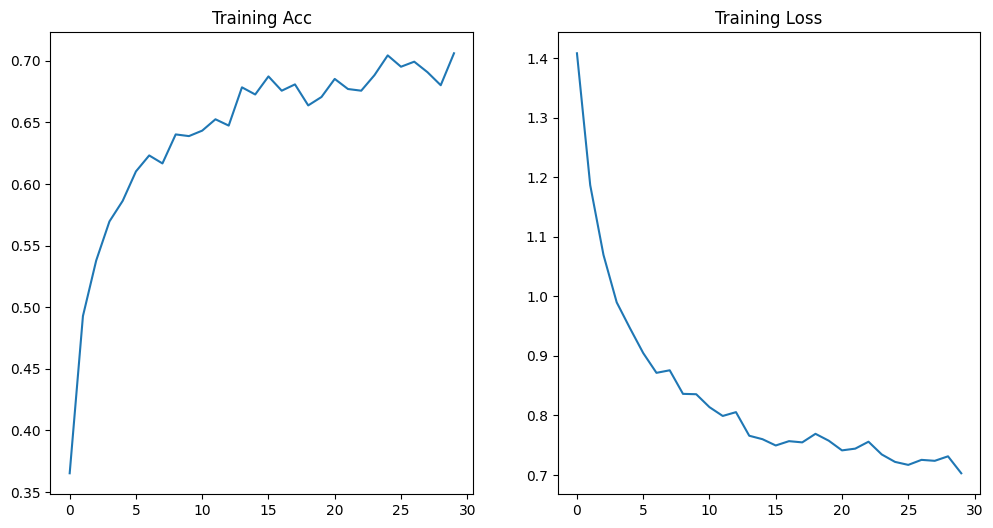

In [12]:
acc = history.history['sparse_categorical_accuracy']
loss = history.history['loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.title('Training Acc')

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.title('Training Loss')
plt.show()

In [13]:
model_tr.save('dis_det')